In [1]:
import sys
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from TransformerEncoder import TransformerEncoder
import torch
import tqdm

sns.set_style("whitegrid")

# simulate no GPU (for checks like torch.cuda.is_available())
os.environ["CUDA_VISIBLE_DEVICES"] = ""

load data

In [2]:
X = np.load("data/x.npy")
y = np.load("data/y.npy")
meta = np.load("data/meta.npy")

x = X[0]

loading model from transformer.pth


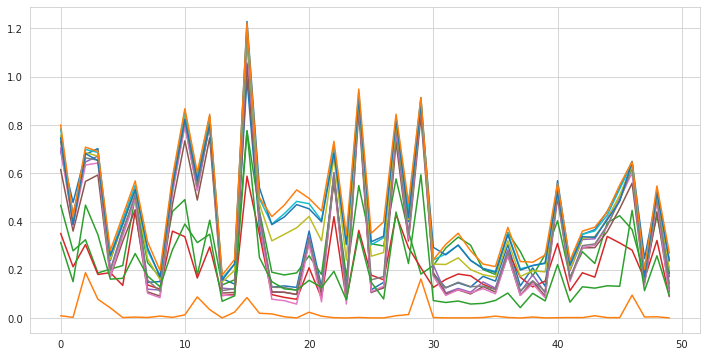

In [3]:
hidden_dims = 128
n_heads = 3
n_layers = 3
dropout=0.262039
d_inner = hidden_dims*4
nclasses=34

transformer = TransformerEncoder(in_channels=13, len_max_seq=70,
            d_word_vec=hidden_dims, d_model=hidden_dims, d_inner=d_inner,
            n_layers=n_layers, n_head=n_heads, d_k=hidden_dims//n_heads, d_v=hidden_dims//n_heads,
            dropout=dropout, nclasses=nclasses)

transformer.load("transformer.pth")
#transformer = transformer.cuda()

fix,ax = plt.subplots(1,figsize=(12,6))
ax.plot(x)
#ax.axis('off')

def totorch(x):
    """single numpy array (txd) to torch batch (1xdxt)"""
    x = torch.Tensor(x).unsqueeze(0).transpose(1,2)
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x

  6%|▌         | 3/50 [00:00<00:01, 28.37it/s]

ScaledDotProductAttention(
  (dropout): Dropout(p=0.1)
  (softmax): Softmax()
)


  6%|▌         | 3/50 [00:00<00:01, 29.35it/s]

ScaledDotProductAttention(
  (dropout): Dropout(p=0.1)
  (softmax): Softmax()
)


100%|██████████| 50/50 [00:02<00:00, 20.56it/s]


(34,)
(34,)


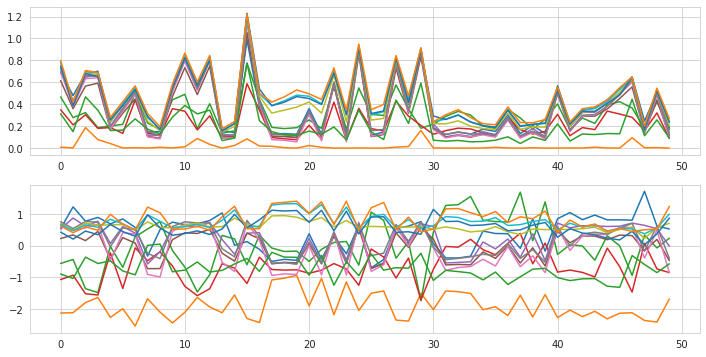

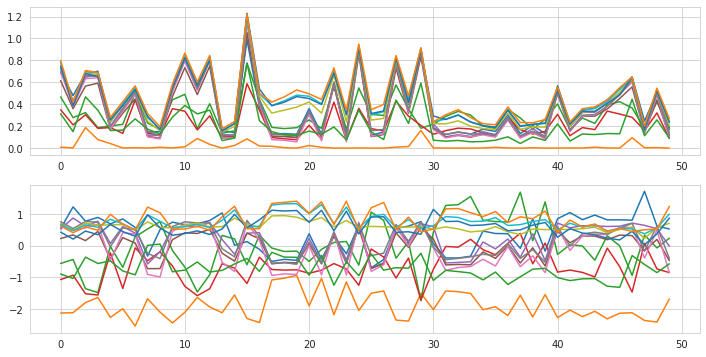

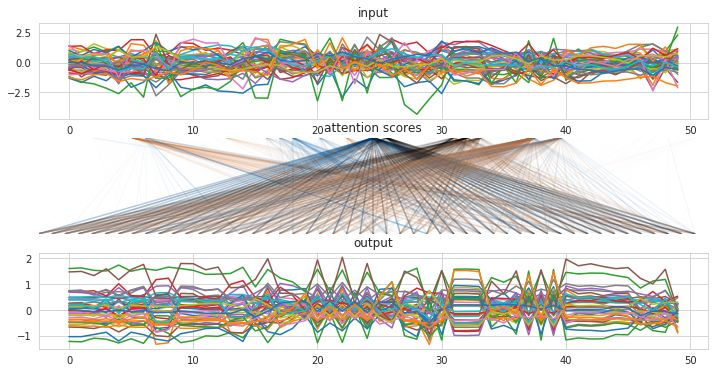

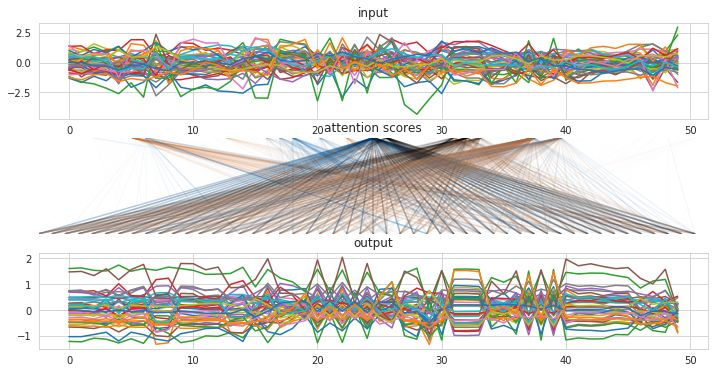

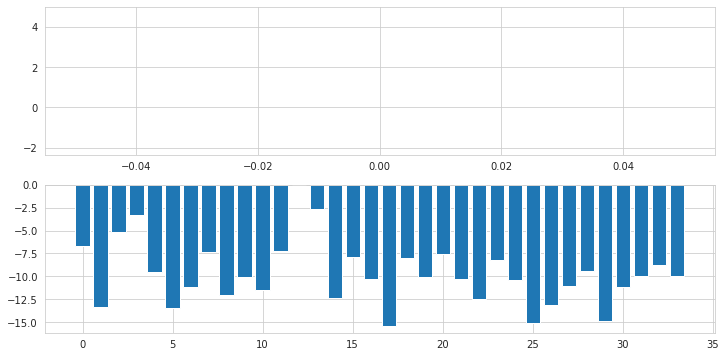

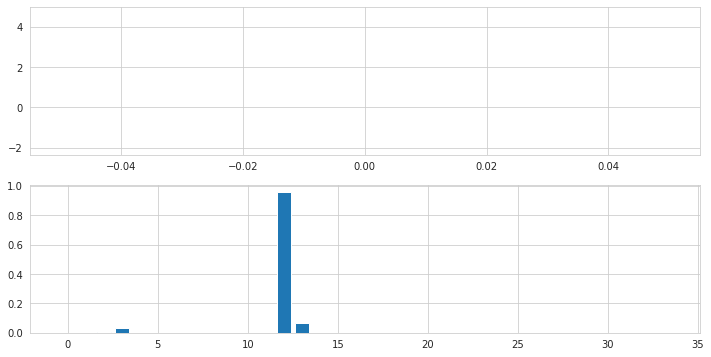

In [9]:
tumorange=(0.89019608, 0.44705882, 0.13333333, 1)
tumblue=(0., 0.39607843, 0.74117647,1)
tumblack=(0,0,0,1)

def attn_plots(ax, arr, mode="conn"):
    assert mode in ["conn","adj"]
    
    if mode =="adj":
        ax.imshow(arr)
        ax.axis('off')
        ax.set_xlabel("out")
        ax.set_ylabel("in")
    
    elif mode=="conn":
        N = arr.shape[1]
        
        ax.set_xlim(0,N)
        for o in tqdm.tqdm(range(N)):
            for i in range(N):
                ax.add_line(Line2D([i,o], [0,1],color=(tumblue[0],tumblue[1],tumblue[2],arr[o,i,0]*.5)))
                ax.add_line(Line2D([i,o], [0,1],color=(tumorange[0],tumorange[1],tumorange[2],arr[o,i,1]*.5)))
                ax.add_line(Line2D([i,o], [0,1],color=(tumblack[0],tumblack[1],tumblack[2],arr[o,i,2]*.5)))
        ax.axis('off')
    return ax
    

def attention_hook(module, inp, out):
    print(module)
    
    enc_output, enc_slf_attn = out
    
    for i in range(enc_slf_attn.shape[0]):
        np.savetxt("/tmp/enc_slf_attn_{}.txt".format(i), enc_slf_attn[i].cpu().detach().numpy(), fmt="%.4f")
    np.savetxt("/tmp/enc_output.txt", enc_output[0].cpu().detach().numpy(), fmt="%.4f")
    
    enc_input, enc_input, enc_input = inp
    
    fig,axs = plt.subplots(3,figsize=(12,6))
    axs[0].plot(enc_input[0].cpu().detach().numpy())
    axs[0].set_title("input")
    
    axs[1] = attn_plots(axs[1], enc_slf_attn.transpose(2,0).cpu().detach().numpy(), mode="conn")
    
    axs[1].set_title("attention scores")
    axs[2].set_title("output")
    axs[2].plot(enc_output[0].cpu().detach().numpy())
    
def outlinear_hook(module, inp, out):
    inp = inp[0].cpu().detach().numpy()
    out = out[0].cpu().detach().numpy()
    print(out.shape)
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp)
    axs[1].bar(np.arange(out.shape[0]), np.exp(out))
    
def inlayernorm_hook(module, inp, out):
    inp = inp[0]
    out = out[0]
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp[0].cpu().detach().numpy())
    axs[1].plot(out.cpu().detach().numpy())
    
def pos_ffn_hook(module, inp, out):
    inp = inp[0]
    out = out[0]
    fig,axs = plt.subplots(2,figsize=(12,6))
    axs[0].plot(inp[0].cpu().detach().numpy())
    axs[1].plot(out.cpu().detach().numpy())
    
    

transformer.zero_grad()
transformer.eval()

transformer.inlayernorm.register_forward_hook(inlayernorm_hook)
transformer.encoder.layer_stack[0].slf_attn.attention.register_forward_hook(attention_hook)
#transformer.encoder.layer_stack[0].pos_ffn.register_forward_hook(pos_ffn_hook)
#transformer.encoder.layer_stack[1].slf_attn.attention.register_forward_hook(attention_hook)
#transformer.encoder.layer_stack[2].slf_attn.attention.register_forward_hook(attention_hook)
transformer.outlinear.register_forward_hook(outlinear_hook)

logprobabilities = transformer.forward(totorch(x))
probas = torch.exp(logprobabilities)


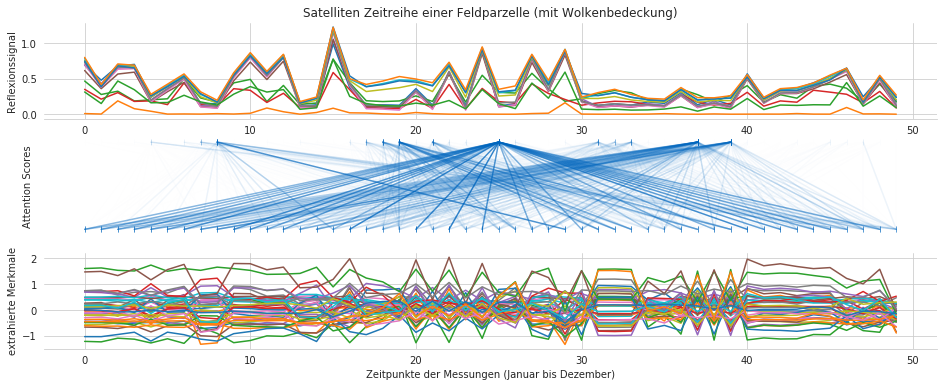

In [7]:
from matplotlib import cm

arr0 = np.loadtxt("/tmp/enc_slf_attn_0.txt")
arr1 = np.loadtxt("/tmp/enc_slf_attn_1.txt")
arr2 = np.loadtxt("/tmp/enc_slf_attn_2.txt")
enc_output = np.loadtxt("/tmp/enc_output.txt")

fig, axs = plt.subplots(3,figsize=(16,6))
sns.despine(ax=axs[0], left=True)
#sns.despine(ax=axs[1])
sns.despine(ax=axs[2], left=True)

axs[0].plot(x)
axs[0].set_title("Satelliten Zeitreihe einer Feldparzelle (mit Wolkenbedeckung)")
axs[0].set_ylabel("Reflexionssignal")
for o in range(arr0.shape[1]):
    for i in range(arr0.shape[0]):
        axs[1].set_xlim(*axs[0].get_xlim())
        axs[1].set_ylim(-.05,1.05)
        axs[1].add_line(Line2D([i,o], [1,0],marker='|',color=(tumblue[0],tumblue[1],tumblue[2],arr0[o,i])))
        #axs[1].plot([i,o], [1,0],'r', alpha=arr0[o,i]*0.5)
        #axs[1].plot([i,o], [1,0],'g', alpha=arr1[o,i]*0.5)
        #axs[1].plot([i,o], [1,0],'b', alpha=arr2[o,i]*0.5)
#axs[1].axis('off')
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])
axs[1].set_ylabel("Attention Scores")
axs[1].set_frame_on(False)
axs[1].grid(False)

axs[2].plot(enc_output)
axs[2].set_ylabel("extrahierte Merkmale")
axs[2].set_xlabel("Zeitpunkte der Messungen (Januar bis Dezember)")

fig.savefig("/tmp/attention.png", dpi=300)

In [8]:
nclasses = probas.shape[1]

rgba_colors = np.zeros((nclasses,4))
rgba_colors[:,2] = 1.0
rgba_colors[:, 3] = probas[0]

plt.scatter(np.arange(nclasses), np.zeros(nclasses), color=rgba_colors, edgecolors=(0,0,.8,1))

NameError: name 'probas' is not defined

In [8]:
np.exp(logprobabilities.cpu().detach())

tensor([1.0000])

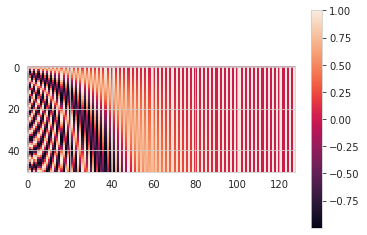

In [20]:
e = transformer.encoder.position_enc.weight.cpu().numpy()
plt.imshow(e)
plt.colorbar()

In [27]:
%%itikz
\documentclass[tikz]{standalone}
\usepackage{pgfplots}
\pgfplotsset{compat=1.15}
\usepackage{catchfile}
\usetikzlibrary{calc}

\begin{filecontents*}{data.csv}
1,4,5,1
2,3,1,5
3,5,6,1
4,1,4,9
\end{filecontents*}

\begin{document}
    \CatchFileDef\loadeddata{#1}{\endlinechar=-1}
\begin{tikzpicture}
 \loadeddata{\i}{\j}

    
%\begin{axis}
%\addplot table [x=a, y=c, col sep=comma] {data.csv};
%\end{axis}
\end{tikzpicture}
\end{document}

(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/kvsetkeys.sty))
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/pdftexcmds.sty)
(/usr/share/texlive/texmf-dist/tex/latex/latexconfig/epstopdf-sys.cfg))
Package pgfplots notification 'compat/show suggested version=true': document ha
s been generated with the most recent feature set (\pgfplotsset{compat=1.15}).


! Illegal parameter number in definition of  .
<to be read again> 
                   1
l.15 ...tchFileDef\loadeddata{#1}{\endlinechar=-1}
                                                  
? 
! Emergency stop.
<to be read again> 
                   1
l.15 ...tchFileDef\loadeddata{#1}{\endlinechar=-1}
                                                  
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on fdf6a4b68829124dcdc7c894d50d77e1.log.


In [9]:


num_layers=4
hidden_dims=32
learning_rate=0.010489
dropout=0.710883
weight_decay=0.000371
bidirectional = True

rnn = RNN(input_dim=13, nclasses=nclasses, hidden_dims=hidden_dims,
                              num_rnn_layers=num_layers, dropout=dropout, bidirectional=bidirectional)

_ = rnn.load("/data/gaf/runs/tumgaf_tum_rnn/model.pth")

loading model from /data/gaf/runs/tumgaf_tum_rnn/model.pth


In [21]:
transformer

TransformerEncoder(
  (inlayernorm): LayerNorm(torch.Size([13]), eps=1e-05, elementwise_affine=True)
  (convlayernorm): LayerNorm(torch.Size([128]), eps=1e-05, elementwise_affine=True)
  (outlayernorm): LayerNorm(torch.Size([128]), eps=1e-05, elementwise_affine=True)
  (inconv): Conv1d(13, 128, kernel_size=(1,), stride=(1,))
  (encoder): Encoder(
    (position_enc): Embedding(51, 128)
    (layer_stack): ModuleList(
      (0): EncoderLayer(
        (slf_attn): MultiHeadAttention(
          (w_qs): Linear(in_features=128, out_features=126, bias=True)
          (w_ks): Linear(in_features=128, out_features=126, bias=True)
          (w_vs): Linear(in_features=128, out_features=126, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1)
            (softmax): Softmax()
          )
          (layer_norm): LayerNorm(torch.Size([128]), eps=1e-05, elementwise_affine=True)
          (fc): Linear(in_features=126, out_features=128, bias=True)
          (d

In [162]:
fix,axs = plt.subplots(2,0,figsize=(12,6))

<Figure size 864x432 with 0 Axes>

In [26]:
model_state = torch.load("/data/gaf/runs/tumgaf_tum_rnn/model.pth", map_location='cpu').pop("model_state")

loading model from /data/gaf/runs/tumgaf_tum_rnn/model.pth


  0%|          | 17/7006 [00:00<00:44, 158.36it/s]

Initializing BavarianCropsDataset test partition in holl
read 34 classes
no cached dataset found. iterating through csv folders in /data/BavarianCrops/csv/holl
Found 7006 ids in /data/BavarianCrops/ids/random/holl_test.txt


100%|██████████| 7006/7006 [00:15<00:00, 442.27it/s]
../src/datasets/BavarianCrops_Dataset.py:169: RuntimeWarning: divide by zero encountered in true_divide
  self.classweights = 1 / self.hist


loaded 6998 samples
Dataset /data/BavarianCrops. region holl. partition test. X:6998x(74, 13), y:(6998,) with 34 classes
